# Coral Reef Bleaching Prediction Using BCO-DMO Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm, metrics
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for barplot
from sklearn.metrics import classification_report

In [ ]:
#original_df = df
# Calculate the number of missing values per row
#missing_per_row = df.isnull().sum(axis=1)

# Create a boolean mask for rows with more than 10 missing values
#rows_to_drop = missing_per_row >= 10

# Filter the DataFrame to keep rows with 10 or fewer missing values
#df = df[~rows_to_drop]

#print(f"Original number of rows: {len(original_df)}")
#print(f"Number of rows after dropping: {len(df)}")

# Save the preprocessed dataframe to a CSV file
#df.to_csv('/preprocessed_data.csv', index=False)

In [2]:
# Load dataset
df = pd.read_csv('/content/global_bleaching_environmental-fixed.csv')

# Replace 'nd' with -9999 and convert to numeric where applicable
df.replace('nd', -9999, inplace=True)
df=df.replace(to_replace=-9999,value=0)
df=df.replace(to_replace="-9999",value="0")
df=df.replace(to_replace="Population",value="1")
print(df["Bleaching_Level"].unique())

# Select all relevant columns except --- as features
X = df.drop(columns=['Bleaching_Level', 'Exposure','Percent_Bleaching','Percent_Cover'])
y = df['Bleaching_Level']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y.astype(str))

[0 '1']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41228 entries, 0 to 41227
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Distance_to_Shore                      41228 non-null  float64
 1   Exposure                               41228 non-null  object 
 2   Turbidity                              41228 non-null  float64
 3   Cyclone_Frequency                      41228 non-null  float64
 4   Depth_m                                41228 non-null  float64
 5   Percent_Cover                          41228 non-null  float64
 6   Bleaching_Level                        41228 non-null  object 
 7   Percent_Bleaching                      41228 non-null  float64
 8   ClimSST                                41228 non-null  float64
 9   Temperature_Kelvin                     41228 non-null  float64
 10  Temperature_Mean                       41228 non-null  float64
 11  Te

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# --- Evaluation Metrics ---
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    return acc, mae, rmse, mape

In [ ]:
# --- Random Forest ---

# Experiment 2.1 - Default
#rf = RandomForestClassifier(n_estimators=100, random_state=42)
#rf.fit(X_train_scaled, y_train)
#rf_pred = rf.predict(X_test_scaled)

# Experiments X
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30, None],
        'max_features': ['sqrt', 'log2', None]
    },
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Evaluate Every Iteration Manually
all_metrics = []

# Iterate through each parameter combination tested
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]

    # Train model with that parameter set
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    acc, mae, rmse, mape = evaluate(y_test, y_pred)

    # Store results
    all_metrics.append({
        'Params': params,
        'Accuracy': acc,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# Show as Table
metrics_df = pd.DataFrame(all_metrics)
print(metrics_df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
                                               Params  Accuracy       MAE  \
0   {'max_depth': 10, 'max_features': 'sqrt', 'n_e...  0.946641  0.053359   
1   {'max_depth': 10, 'max_features': 'sqrt', 'n_e...  0.946156  0.053844   
2   {'max_depth': 10, 'max_features': 'log2', 'n_e...  0.946277  0.053723   
3   {'max_depth': 10, 'max_features': 'log2', 'n_e...  0.946520  0.053480   
4   {'max_depth': 10, 'max_features': None, 'n_est...  0.948945  0.051055   
5   {'max_depth': 10, 'max_features': None, 'n_est...  0.949551  0.050449   
6   {'max_depth': 20, 'max_features': 'sqrt', 'n_e...  0.987873  0.012127   
7   {'max_depth': 20, 'max_features': 'sqrt', 'n_e...  0.988601  0.011399   
8   {'max_depth': 20, 'max_features': 'log2', 'n_e...  0.988601  0.011399   
9   {'max_depth': 20, 'max_features': 'log2', 'n_e...  0.989449  0.010551   
10  {'max_depth': 20, 'max_features': None, 'n_est...  0.985811  0.014189   
11  {'max_depth

In [5]:
# --- SVM ---

# Experiments V2 (24)
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 0.1],        # applicable to rbf, poly, sigmoid
    'degree': [3]                   # only used for poly
}

# Create GridSearchCV (to get all param combinations)
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

svm_grid.fit(X_train_scaled, y_train)

# Manual Evaluation for Each Combination
all_svm_metrics = []

for i in range(len(svm_grid.cv_results_['params'])):
    params = svm_grid.cv_results_['params'][i]

    # Create and fit model with current parameters
    model = SVC(**params)
    model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    acc, mae, rmse, mape = evaluate(y_test, y_pred)

    # Store results
    all_svm_metrics.append({
    'C': params['C'],
    'Kernel': params['kernel'],
    'Gamma': params['gamma'],
    'Degree': params.get('degree', '-'),  # Only used in poly
    'Accuracy': acc,
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
})

# Create DataFrame to display
svm_metrics_df = pd.DataFrame(all_svm_metrics)

# Show the full result table
print("\n📋 All SVM Experiment Results:")
print(svm_metrics_df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

📋 All SVM Experiment Results:
       C   Kernel  Gamma  Degree  Accuracy       MAE      RMSE       MAPE
0    0.1   linear  scale       3  0.760005  0.239995  0.489893  23.999515
1    0.1      rbf  scale       3  0.761703  0.238297  0.488157  23.829736
2    0.1     poly  scale       3  0.799539  0.200461  0.447729  20.046083
3    0.1  sigmoid  scale       3  0.444215  0.555785  0.745510  55.578462
4    0.1   linear    0.1       3  0.760005  0.239995  0.489893  23.999515
5    0.1      rbf    0.1       3  0.721926  0.278074  0.527327  27.807422
6    0.1     poly    0.1       3  0.686757  0.313243  0.559681  31.324278
7    0.1  sigmoid    0.1       3  0.670386  0.329614  0.574121  32.961436
8    1.0   linear  scale       3  0.790323  0.209677  0.457905  20.967742
9    1.0      rbf  scale       3  0.826098  0.173902  0.417016  17.390250
10   1.0     poly  scale       3  0.850352  0.149648  0.386844  14.964831
11   1.0  sigmoid  s

In [ ]:
# --- LSTM ---
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
lstm_pred_prob = lstm.predict(X_test_lstm)
lstm_pred = [1 if x > 0.5 else 0 for x in lstm_pred_prob]

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6165 - loss: 0.6525
Epoch 2/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7352 - loss: 0.5551
Epoch 3/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7553 - loss: 0.5340
Epoch 4/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7659 - loss: 0.5171
Epoch 5/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7740 - loss: 0.4999
Epoch 6/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7825 - loss: 0.4893
Epoch 7/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7874 - loss: 0.4800
Epoch 8/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7865 - loss: 0.4765
Epoch 9/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7920 - loss: 0.4648
Epoch 10/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7914 - loss: 0.4655
Epoch 11/50
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7980 - loss: 0.4570
Epoch 12/50
1031/1031 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# --- LSTM Experiments ---
#24 experiments
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product

# Reshape input for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Hyperparameters to test
units = [64, 128, 32]
dropouts = [0.2, 0.5]
batch_sizes = [32, 64]
optimizers = ['adam', 'rmsprop']

# Generate all configurations
lstm_configs = [
    {'units': u, 'dropout': d, 'batch_size': b, 'optimizer': o}
    for u, d, b, o in product(units, dropouts, batch_sizes, optimizers)
]

# Store results
lstm_results = []

for cfg in lstm_configs:
    print(f"\nTraining LSTM with config: {cfg}")

    # Build model
    model = Sequential()
    model.add(LSTM(units=cfg['units'], input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(cfg['dropout']))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=cfg['optimizer'], metrics=['accuracy'])

    # Train
    history = model.fit(
        X_train_lstm, y_train,
        epochs=30,
        batch_size=cfg['batch_size'],
        verbose=1
    )

    # Predict
    y_pred_prob = model.predict(X_test_lstm)
    y_pred = (y_pred_prob > 0.5).astype('int32')

    # Evaluate
    acc, mae, rmse, mape = evaluate(y_test, y_pred)

    lstm_results.append({
        'units': cfg['units'],
        'dropout': cfg['dropout'],
        'batch_size': cfg['batch_size'],
        'optimizer': cfg['optimizer'],
        'Accuracy': acc,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# Save results
lstm_results_df = pd.DataFrame(lstm_results)
print("\n📊 LSTM Tuning Results:")
print(lstm_results_df.sort_values(by='Accuracy', ascending=False))


Training LSTM with config: {'units': 64, 'dropout': 0.2, 'batch_size': 32, 'optimizer': 'adam'}
Epoch 1/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6086 - loss: 0.6565
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7241 - loss: 0.5665
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7550 - loss: 0.5356
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7622 - loss: 0.5194
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7729 - loss: 0.5067
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7784 - loss: 0.4926
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7839 - loss: 0.4859
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7860 - loss: 0.4844
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7904 - loss: 0.4722
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7944 - loss: 0.4650
Epoch 11/30
1031/103

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5949 - loss: 0.6647
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7163 - loss: 0.5762
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7441 - loss: 0.5468
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7553 - loss: 0.5304
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7703 - loss: 0.5129
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7694 - loss: 0.5105
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7774 - loss: 0.4991
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7792 - loss: 0.4939
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7793 - loss: 0.4920
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7844 - loss: 0.4841
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7847 - loss: 0.4816
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5867 - loss: 0.6682
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7091 - loss: 0.5808
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7450 - loss: 0.5454
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7588 - loss: 0.5288
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7677 - loss: 0.5139
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7746 - loss: 0.5043
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7808 - loss: 0.4986
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7745 - loss: 0.4943
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7846 - loss: 0.4829
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7869 - loss: 0.4802
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7871 - loss: 0.4736
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5770 - loss: 0.6738
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6954 - loss: 0.6018
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7186 - loss: 0.5689
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7436 - loss: 0.5441
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7575 - loss: 0.5332
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7675 - loss: 0.5207
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7652 - loss: 0.5170
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7771 - loss: 0.5028
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7741 - loss: 0.5014
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7779 - loss: 0.4971
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7785 - loss: 0.4964
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6025 - loss: 0.6628
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7160 - loss: 0.5764
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7369 - loss: 0.5518
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7557 - loss: 0.5336
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7587 - loss: 0.5284
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7680 - loss: 0.5152
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7742 - loss: 0.5026
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7778 - loss: 0.4919
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7792 - loss: 0.4891
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7865 - loss: 0.4806
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7876 - loss: 0.4731
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5889 - loss: 0.6692
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7024 - loss: 0.5911
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7314 - loss: 0.5602
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7472 - loss: 0.5416
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7574 - loss: 0.5333
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7629 - loss: 0.5225
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7657 - loss: 0.5169
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7734 - loss: 0.5039
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7738 - loss: 0.4992
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7810 - loss: 0.4973
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7746 - loss: 0.4961
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5854 - loss: 0.6694
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7046 - loss: 0.5939
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7268 - loss: 0.5649
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7446 - loss: 0.5480
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7567 - loss: 0.5295
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7632 - loss: 0.5223
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7678 - loss: 0.5117
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7735 - loss: 0.5058
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7782 - loss: 0.4998
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7807 - loss: 0.4933
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7825 - loss: 0.4896
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5686 - loss: 0.6788
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6899 - loss: 0.6135
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7112 - loss: 0.5787
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7372 - loss: 0.5550
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7427 - loss: 0.5463
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7584 - loss: 0.5292
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7593 - loss: 0.5248
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7653 - loss: 0.5249
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7690 - loss: 0.5148
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7729 - loss: 0.5129
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7731 - loss: 0.5059
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6277 - loss: 0.6454
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7337 - loss: 0.5520
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7614 - loss: 0.5275
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7701 - loss: 0.5088
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7797 - loss: 0.4937
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7828 - loss: 0.4821
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7870 - loss: 0.4807
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7894 - loss: 0.4739
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7982 - loss: 0.4624
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7988 - loss: 0.4564
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8050 - loss: 0.4477
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.6613
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7132 - loss: 0.5705
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7441 - loss: 0.5412
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7594 - loss: 0.5242
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7682 - loss: 0.5183
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7741 - loss: 0.5045
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7710 - loss: 0.4972
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7824 - loss: 0.4852
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7756 - loss: 0.4928
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7808 - loss: 0.4803
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7873 - loss: 0.4776
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6034 - loss: 0.6614
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7189 - loss: 0.5723
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7452 - loss: 0.5398
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7618 - loss: 0.5271
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7720 - loss: 0.5083
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7811 - loss: 0.4950
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7862 - loss: 0.4863
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7886 - loss: 0.4795
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7879 - loss: 0.4791
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7845 - loss: 0.4744
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7891 - loss: 0.4706
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5845 - loss: 0.6720
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7021 - loss: 0.5908
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7353 - loss: 0.5539
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7511 - loss: 0.5393
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7593 - loss: 0.5326
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7627 - loss: 0.5180
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7750 - loss: 0.5077
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7719 - loss: 0.5014
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7772 - loss: 0.4983
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7815 - loss: 0.4909
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7825 - loss: 0.4903
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6051 - loss: 0.6608
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7218 - loss: 0.5656
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7532 - loss: 0.5353
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7577 - loss: 0.5249
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7715 - loss: 0.5091
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7726 - loss: 0.5047
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7800 - loss: 0.4903
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7817 - loss: 0.4888
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7846 - loss: 0.4797
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7855 - loss: 0.4802
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7920 - loss: 0.4639
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5957 - loss: 0.6659
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7085 - loss: 0.5865
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7365 - loss: 0.5526
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7544 - loss: 0.5306
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7586 - loss: 0.5281
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7638 - loss: 0.5179
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7685 - loss: 0.5095
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7748 - loss: 0.5014
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7803 - loss: 0.4958
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7774 - loss: 0.4922
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7754 - loss: 0.4952
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5910 - loss: 0.6680
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7086 - loss: 0.5830
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7367 - loss: 0.5525
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7524 - loss: 0.5395
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7627 - loss: 0.5276
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7688 - loss: 0.5123
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7717 - loss: 0.5079
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7757 - loss: 0.4962
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7760 - loss: 0.5033
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7867 - loss: 0.4791
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7872 - loss: 0.4834
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5758 - loss: 0.6753
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6927 - loss: 0.6060
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7234 - loss: 0.5711
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7437 - loss: 0.5472
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7521 - loss: 0.5413
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7592 - loss: 0.5279
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7606 - loss: 0.5256
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7701 - loss: 0.5120
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7716 - loss: 0.5061
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7750 - loss: 0.5053
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7766 - loss: 0.5030
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5956 - loss: 0.6630
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7118 - loss: 0.5753
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7438 - loss: 0.5422
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7583 - loss: 0.5280
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7671 - loss: 0.5125
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7729 - loss: 0.5054
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7787 - loss: 0.4911
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7841 - loss: 0.4869
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7898 - loss: 0.4803
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7933 - loss: 0.4685
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7961 - loss: 0.4657
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5815 - loss: 0.6701
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7048 - loss: 0.5861
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7349 - loss: 0.5519
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7533 - loss: 0.5362
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7644 - loss: 0.5240
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7700 - loss: 0.5139
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7736 - loss: 0.5087
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7732 - loss: 0.5047
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7758 - loss: 0.5033
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7819 - loss: 0.4925
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7849 - loss: 0.4831
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5715 - loss: 0.6752
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6984 - loss: 0.5946
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7288 - loss: 0.5608
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7458 - loss: 0.5449
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7575 - loss: 0.5264
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7667 - loss: 0.5218
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7739 - loss: 0.5071
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7785 - loss: 0.4984
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7808 - loss: 0.4938
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7825 - loss: 0.4900
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7856 - loss: 0.4741
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5585 - loss: 0.6812
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6818 - loss: 0.6206
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7105 - loss: 0.5778
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7339 - loss: 0.5551
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7383 - loss: 0.5514
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7554 - loss: 0.5310
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7654 - loss: 0.5240
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7637 - loss: 0.5243
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7725 - loss: 0.5095
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7756 - loss: 0.5048
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7761 - loss: 0.4987
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5809 - loss: 0.6722
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7031 - loss: 0.5921
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7318 - loss: 0.5602
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7481 - loss: 0.5415
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7611 - loss: 0.5288
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7630 - loss: 0.5209
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7709 - loss: 0.5125
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7805 - loss: 0.4945
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7749 - loss: 0.5040
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7753 - loss: 0.4958
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7806 - loss: 0.4862
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5739 - loss: 0.6737
Epoch 2/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6962 - loss: 0.6010
Epoch 3/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7240 - loss: 0.5693
Epoch 4/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7377 - loss: 0.5578
Epoch 5/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7543 - loss: 0.5390
Epoch 6/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7570 - loss: 0.5298
Epoch 7/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7646 - loss: 0.5170
Epoch 8/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7669 - loss: 0.5191
Epoch 9/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7734 - loss: 0.5078
Epoch 10/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7717 - loss: 0.5060
Epoch 11/30
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7751 - loss: 0.5016
Epoch 12/30
1031/1031 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5699 - loss: 0.6780
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6888 - loss: 0.6104
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7215 - loss: 0.5722
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7414 - loss: 0.5528
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7478 - loss: 0.5438
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7645 - loss: 0.5258
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7638 - loss: 0.5291
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7691 - loss: 0.5158
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7775 - loss: 0.5068
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7761 - loss: 0.5015
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7789 - loss: 0.4969
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5575 - loss: 0.6825
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6720 - loss: 0.6319
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6970 - loss: 0.5975
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7136 - loss: 0.5752
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7285 - loss: 0.5631
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7391 - loss: 0.5515
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7516 - loss: 0.5415
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7579 - loss: 0.5331
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7599 - loss: 0.5318
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7704 - loss: 0.5167
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7671 - loss: 0.5181
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy

In [ ]:
# --- XGBoost ---
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

# XGBoost Hyperparameter grid (24 experiments)
param_grid = {
    'n_estimators': [100, 200, 300, 400],       # model complexity & performance / default 100
    'max_depth': [3, 6, 10],               # shallow, medium, deep trees / default 6
    'learning_rate': [0.1, 0.3]      # slow to fast learning / default 0.3
}

# Run Experiments
xgb_results = []
grid = list(ParameterGrid(param_grid))

for params in grid:
    print(f"\n🔧 Training with: {params}")
    xgb = XGBClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    xgb.fit(X_train_scaled, y_train)
    xgb_pred = xgb.predict(X_test_scaled)

    acc, mae, rmse, mape = evaluate(y_test, xgb_pred)

    xgb_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'Accuracy': acc,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# XGBoost Results
xgb_results_df = pd.DataFrame(xgb_results)
print("\n📊 XGBoost Tuning Results:")
print(xgb_results_df.sort_values(by='Accuracy', ascending=False))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 400}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 400}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:34:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:34:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔧 Training with: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 400}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Tuning Results:
    n_estimators  max_depth  learning_rate  Accuracy       MAE      RMSE  \
23           400         10            0.3  0.992845  0.007155  0.084587   
11           400         10            0.1  0.992602  0.007398  0.086009   
21           200         10            0.3  0.992481  0.007519  0.086711   
22           300         10            0.3  0.992239  0.007761  0.088098   
20           100         10            0.3  0.992239  0.007761  0.088098   
10           300         10            0.1  0.992117  0.007883  0.088784   
19           400          6            0.3  0.991511  0.008489  0.092136   
18           300          6            0.3  0.991268  0.008732  0.093443   
9            200         10            0.1  0.991147  0.008853  0.094089   
17           200          6            0.3  0.988964  0.011036  0.105051   
7            400          6            0.1  0.983992  0.016008  0.126522   
8            100         10            0.1  0.983628  0.01637

In [ ]:
# --- Decision Tree ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
dt_pred = dt.predict(X_test_scaled)

# DT Hyperparameter Grid (24 Experiments)
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = list(ParameterGrid(dt_param_grid))
dt_results = []

for i, params in enumerate(grid):
    print(f"\n🌳 Training DT {i+1}/{len(grid)} with: {params}")

    dt = DecisionTreeClassifier(**params, random_state=42)
    dt.fit(X_train_scaled, y_train)
    dt_pred = dt.predict(X_test_scaled)

    acc, mae, rmse, mape = evaluate(y_test, dt_pred)

    dt_results.append({
        **params,
        'Accuracy': acc,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# DT Results
dt_results_df = pd.DataFrame(dt_results)
print("\n📊 Decision Tree Results:")
print(dt_results_df.sort_values(by='Accuracy', ascending=False))


🌳 Training DT 1/24 with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}

🌳 Training DT 2/24 with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}

🌳 Training DT 3/24 with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}

🌳 Training DT 4/24 with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

🌳 Training DT 5/24 with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}

🌳 Training DT 6/24 with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}

🌳 Training DT 7/24 with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}

🌳 Training DT 8/24 with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}

🌳 Training DT 9/24 with: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}

🌳 Training DT 10/24 with: {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}

🌳 Training DT 11/24 with: {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 5}

🌳 Trainin

In [ ]:
# --- MLP Classifier ---
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)

# MLP Hyperparameter Grid (24 experiments)
mlp_param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64, 32), (128,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01]
}

grid = list(ParameterGrid(mlp_param_grid))
mlp_results = []

for i, params in enumerate(grid):
    print(f"\n🧠 Training MLP {i+1}/{len(grid)} with: {params}")

    mlp = MLPClassifier(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        learning_rate_init=params['learning_rate_init'],
        solver='adam',
        max_iter=300,
        random_state=42
    )

    mlp.fit(X_train_scaled, y_train)
    mlp_pred = mlp.predict(X_test_scaled)

    acc, mae, rmse, mape = evaluate(y_test, mlp_pred)

    mlp_results.append({
        **params,
        'Accuracy': acc,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

# MLP Results
mlp_results_df = pd.DataFrame(mlp_results)
print("\n📊 MLP Experiment Results:")
print(mlp_results_df.sort_values(by='Accuracy', ascending=False))


🧠 Training MLP 1/24 with: {'activation': 'relu', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 2/24 with: {'activation': 'relu', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}

🧠 Training MLP 3/24 with: {'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001}

🧠 Training MLP 4/24 with: {'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}

🧠 Training MLP 5/24 with: {'activation': 'relu', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}

🧠 Training MLP 6/24 with: {'activation': 'relu', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.01}

🧠 Training MLP 7/24 with: {'activation': 'relu', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 8/24 with: {'activation': 'relu', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}

🧠 Training MLP 9/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 10/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}

🧠 Training MLP 11/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001}

🧠 Training MLP 12/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}

🧠 Training MLP 13/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 14/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.01}

🧠 Training MLP 15/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 16/24 with: {'activation': 'tanh', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}

🧠 Training MLP 17/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 18/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}

🧠 Training MLP 19/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 20/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 21/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 22/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.01}

🧠 Training MLP 23/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



🧠 Training MLP 24/24 with: {'activation': 'logistic', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}

📊 MLP Experiment Results:
   activation hidden_layer_sizes  learning_rate_init  Accuracy       MAE  \
4        relu      (128, 64, 32)               0.001  0.964468  0.035532   
12       tanh      (128, 64, 32)               0.001  0.963983  0.036017   
21   logistic      (128, 64, 32)               0.010  0.951734  0.048266   
19   logistic           (64, 32)               0.010  0.945307  0.054693   
5        relu      (128, 64, 32)               0.010  0.934271  0.065729   
10       tanh           (64, 32)               0.001  0.929784  0.070216   
2        relu           (64, 32)               0.001  0.927359  0.072641   
23   logistic             (128,)               0.010  0.926389  0.073611   
6        relu             (128,)               0.001  0.926025  0.073975   
11       tanh           (64, 32)               0.010  0.925782  0.074218   
15       tanh           

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# --- Results ---
rf_metrics = evaluate(y_test, rf_pred)
svm_metrics = evaluate(y_test, svm_pred)
lstm_metrics = evaluate(y_test, lstm_pred)
xgb_metrics = evaluate(y_test, xgb_pred)
dt_metrics = evaluate(y_test, dt_pred)
mlp_metrics = evaluate(y_test, mlp_pred)

results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'LSTM', 'XGBoost', 'Decision Tree', 'Multilayer Perceptron' ],
    'Accuracy': [rf_metrics[0], svm_metrics[0], lstm_metrics[0], xgb_metrics[0], dt_metrics[0], mlp_metrics[0]],
    'MAE': [rf_metrics[1], svm_metrics[1], lstm_metrics[1], xgb_metrics[1], dt_metrics[1], mlp_metrics[1]],
    'RMSE': [rf_metrics[2], svm_metrics[2], lstm_metrics[2], xgb_metrics[2], dt_metrics[2], mlp_metrics[2]],
    'MAPE': [rf_metrics[3], svm_metrics[3], lstm_metrics[3], xgb_metrics[3], dt_metrics[3], mlp_metrics[3]]
})

print(results)

                   Model  Accuracy       MAE      RMSE       MAPE
0          Random Forest  0.992117  0.007883  0.088784   0.788261
1                    SVM  0.826098  0.173902  0.417016  17.390250
2                   LSTM  0.869755  0.130245  0.360895  13.024497
3                XGBoost  0.979626  0.020374  0.142736   2.037351
4          Decision Tree  0.986660  0.013340  0.115498   1.333980
5  Multilayer Perceptron  0.925661  0.074339  0.272652   7.433907


In [ ]:
# Define the models dictionary
models = {
    "Random Forest": rf_pred,
    "SVM": svm_pred,
    "LSTM": lstm_pred,
    "XGBoost": xgb_pred,
    "Decision Tree": dt_pred,
    "Multilayer Perceptron": mlp_pred
}

Top 15 Feature Importances:
- Turbidity: 0.1712
- SSTA_Standard_Deviation: 0.1167
- Temperature_Mean: 0.0519
- Distance_to_Shore: 0.0359
- Cyclone_Frequency: 0.0330
- Temperature_Kelvin_Standard_Deviation: 0.0323
- TSA_Mean: 0.0321
- TSA_Standard_Deviation: 0.0295
- TSA_DHW_Standard_Deviation: 0.0258
- TSA_Frequency_Standard_Deviation: 0.0238
- SSTA_DHWMean: 0.0235
- TSA: 0.0230
- Temperature_Kelvin: 0.0227
- SSTA_Frequency_Standard_Deviation: 0.0224
- SSTA_DHW_Standard_Deviation: 0.0220


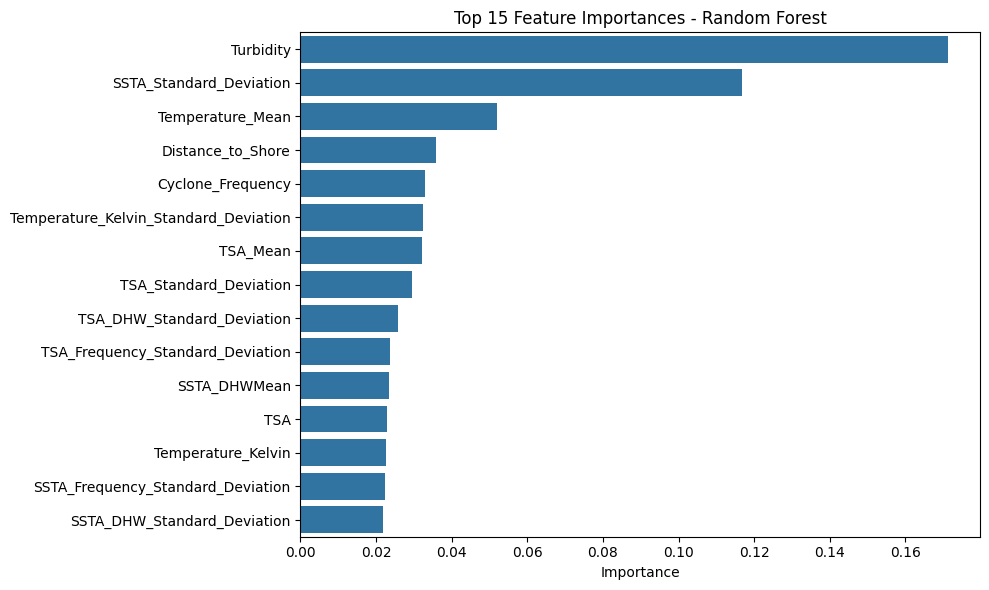

In [ ]:
# --- Plot Feature Importance (Using RF) ---
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = np.array(X.columns)[indices][:15]

top_15_features_with_importance = [(X.columns[i], importances[i]) for i in indices[:15]]

# Print the list
top_15_features_with_importance = [(X.columns[i], importances[i]) for i in indices[:15]]
print("Top 15 Feature Importances:")
for feature, importance in top_15_features_with_importance:
    print(f"- {feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:15], y=top_features)
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
# --- Classification Report Table ---
for name, preds in models.items():
    print(f"=== {name} ===")
    print(classification_report(y_test, preds))

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3852
           1       0.99      1.00      0.99      4394

    accuracy                           0.99      8246
   macro avg       0.99      0.99      0.99      8246
weighted avg       0.99      0.99      0.99      8246

=== SVM ===
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      3852
           1       0.78      0.94      0.85      4394

    accuracy                           0.83      8246
   macro avg       0.84      0.82      0.82      8246
weighted avg       0.84      0.83      0.82      8246

=== LSTM ===
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      3852
           1       0.83      0.95      0.89      4394

    accuracy                           0.87      8246
   macro avg       0.88      0.86      0.87      8246
weighted avg       0.88    